# Detailed Example

This example shows how to use the pinch package and explains each step in detail.

## Creating streams
A stream can consist of one or multiple segments. So let's first create a cold segment that requires 360 kW to be heated from 30 °C to 150 °C.

In [1]:
from pinch import segment
cold_segment = segment.new(-360, 30, 150)  # Heat flow, supply temperature, target temperature

The most common convention which is also used in this package is that cold streams (and segments) have negative heat flow and hot streams have positive heat flow.  
The units are not explicitly stated here. You can use any units you like as long as they are consistent.

We can now create a stream from this segment.

In [2]:
from pinch.stream import Stream
cold_stream = Stream([cold_segment])

The square brackets are needed because Stream accepts a list of segments.  
Let's create another stream, this time a hot stream consisting of multiple segments.

In [3]:
hot_stream = Stream([
    segment.new(20, 140, 100),
    segment.new(90, 100, 100),  # Latent heat
    segment.new(30, 100, 60)
])

The second segment has equal supply and target temperature and represents a latent heat load (condensation in this case).

## Calculating energy targets

We can use the `StreamAnalyzer` class to perform a pinch analysis.

In [4]:
from pinch.stream_analyzer import StreamAnalyzer
min_temp_diff = 10
default_temp_shift = min_temp_diff / 2
analyzer = StreamAnalyzer(default_temp_shift, [cold_stream, hot_stream])

### Shifted Temperature

We need to shift the temperatures to account for the temperature difference between hot and cold streams. It can also be set for individual streams and segments. If it is given, the default value is ignored.

In [5]:
another_cold_stream = Stream([
    segment.new(-20, 5, 20, 2)  # The last argument is temp_shift=2
])
another_hot_stream = Stream([segment.new(160, 60, 20)])
analyzer.add([another_cold_stream, another_hot_stream])

We can now obtain the energy targets from the stream analyzer.

In [6]:
analyzer.heating_demand

380.0

In [7]:
analyzer.cooling_demand

300.0

In [8]:
analyzer.hot_utility_target

160.0

In [9]:
analyzer.cold_utility_target

80.0

In [10]:
analyzer.heat_recovery_target

220.0

In [11]:
analyzer.pinch_temps  # Returns a list because multiple pinches are possible

[55.0, 95.0]

It can also give us heat cascades that can be used to plot composite curves.

In [12]:
(cc_heat_flows, cc_temps) = analyzer.cold_cascade.cumulative_heat_flow
print(
    "Cold cascade\nHeat flows: {}\nTemperatures: {}"
    .format(cc_heat_flows, cc_temps)
)

Cold cascade
Heat flows: [80.0, 100.0, 100.0, 460.0]
Temperatures: [5, 20, 30, 150]


Aside from `cold_cascade`, this also works for `hot_cascade`, `shifted_cold_cascade`, `shifted_hot_cascade` and `grand_cascade`.

In [13]:
print(
    "Shifted cold cascade\nHeat flows: {}\nTemperatures: {}"
    .format(*analyzer.shifted_cold_cascade.cumulative_heat_flow)
)

Shifted cold cascade
Heat flows: [80.0, 100.0, 100.0, 460.0]
Temperatures: [7, 22, 35.0, 155.0]


We can see that the temperatures 5 °C and 20 °C have been shifted by 2 K to 7 °C and 22 °C, while 30 °C and 150 °C have been shifted by 5 K to 35 °C and 155 °C. This is because we used a default temperature shift of 5 K, but `another_cold_stream` has an individual temperature shift of 2 K.

## Plotting composite curves

This data can be used to plot composite curves. Here's an example using matplotlib.

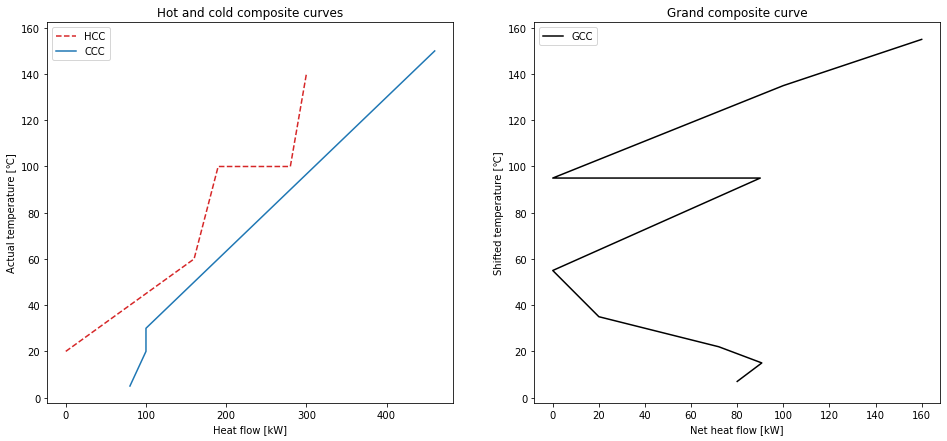

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].plot(*analyzer.hot_cascade.cumulative_heat_flow, color="tab:red", linestyle="--", label="HCC")
ax[0].plot(*analyzer.cold_cascade.cumulative_heat_flow, color="tab:blue", linestyle="-", label="CCC")
ax[0].legend()
ax[0].set_title("Hot and cold composite curves")
ax[0].set_xlabel("Heat flow [kW]")
ax[0].set_ylabel("Actual temperature [\u2103]")

ax[1].plot(*analyzer.grand_cascade.cumulative_heat_flow, color="k", linestyle="-", label="GCC")
ax[1].legend()
ax[1].set_title("Grand composite curve")
ax[1].set_xlabel("Net heat flow [kW]")
ax[1].set_ylabel("Shifted temperature [\u2103]")

# Make the y-axis equal in both plots
ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
minmax_ylims = (min(ylims), max(ylims))
ax[0].set_ylim(minmax_ylims)
ax[1].set_ylim(minmax_ylims)

plt.show()